In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset, myNormalize, myToTensor
from torchvision import transforms

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
mynorm = myNormalize()
my_to_tensor = myToTensor()
transform = transforms.Compose([mynorm, my_to_tensor])

In [4]:
train_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\train\\','D:\python\SoilNet\dataset\LUCAS_2015_Germany_all.csv', transform=transform)
test_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\test\\','D:\python\SoilNet\dataset\LUCAS_2015_Germany_all.csv', transform=transform)

In [5]:
# CONFIG
NUM_WORKERS = 2
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 2

In [18]:
train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [19]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dl))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([8, 12, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


In [20]:
from soilnet.soil_net import SoilNetFC

In [21]:
model = SoilNetFC(cnn_in_channels=12, regresor_input=1024, hidden_size=128).to(device)
img_gpu = img_custom.to(device)
print(img_gpu.device)
y = model(img_gpu[1])
y.detach()


cuda:0


tensor([0.0501], device='cuda:0')

In [22]:
torch.min(img_gpu[0]) , torch.min(img_gpu[1])

(tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

In [23]:
def train_step(model:nn.Module, data_loader:DataLoader, loss_fn:nn.Module, optimizer:torch.optim.Optimizer):
    size = len(data_loader.dataset)
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss = 0
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)


        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss = train_loss / len(data_loader)
    return train_loss

In [24]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [25]:
x= train_step(model, train_dl, RMSELoss(), torch.optim.Adam(model.parameters(), lr=1e-4))
x

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.223261  [    0/   80]
loss: 0.070480  [   16/   80]
loss: 0.076602  [   32/   80]
loss: 0.051517  [   48/   80]
loss: 0.143018  [   64/   80]


0.1280114848166704

In [26]:
# Test step function
def test_step(model:nn.Module, data_loader:DataLoader, loss_fn:nn.Module):
    size = len(data_loader.dataset)
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            # if batch % 2 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    test_loss /= len(data_loader)
    print(f"Test Loss: {test_loss:>8f}%")
    return test_loss

In [27]:
x= test_step(model, test_dl, RMSELoss())
x

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.076385%


0.07638538237661123

In [28]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = RMSELoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss = test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | ",
            f"train_loss: {train_loss} | ",
            f"test_loss: {test_loss} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # 6. Return the filled results at the end of the epochs
    return results

## ~~Model is to Small it can't even overfit! | try RESNET~~
## A lower learning rate (1e-5) solved out problem!

In [33]:
results = train(model, train_dl, test_dl, torch.optim.Adam(model.parameters(), lr=1e-5), RMSELoss(), epochs=10) # Make| sure set shuffle for train back to True after testing

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.199405  [    0/   80]
loss: 0.071702  [   16/   80]
loss: 0.093936  [   32/   80]
loss: 0.041776  [   48/   80]
loss: 0.144115  [   64/   80]


c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:08<01:12,  8.09s/it]

Test Loss: 0.080505%
Epoch: 1 |  train_loss: 0.12435317225754261 |  test_loss: 0.08050469011068344 | 
loss: 0.195885  [    0/   80]
loss: 0.070044  [   16/   80]
loss: 0.084229  [   32/   80]
loss: 0.040904  [   48/   80]
loss: 0.140931  [   64/   80]


 20%|██        | 2/10 [00:16<01:04,  8.11s/it]

Test Loss: 0.076354%
Epoch: 2 |  train_loss: 0.12051841877400875 |  test_loss: 0.07635401636362076 | 
loss: 0.195198  [    0/   80]
loss: 0.069966  [   16/   80]
loss: 0.079264  [   32/   80]
loss: 0.038829  [   48/   80]
loss: 0.139921  [   64/   80]


 30%|███       | 3/10 [00:23<00:55,  7.95s/it]

Test Loss: 0.073609%
Epoch: 3 |  train_loss: 0.11908767446875572 |  test_loss: 0.07360888216644526 | 
loss: 0.195018  [    0/   80]
loss: 0.069775  [   16/   80]
loss: 0.074950  [   32/   80]
loss: 0.035966  [   48/   80]
loss: 0.139218  [   64/   80]


 40%|████      | 4/10 [00:31<00:46,  7.74s/it]

Test Loss: 0.072040%
Epoch: 4 |  train_loss: 0.11782447434961796 |  test_loss: 0.07204006575047969 | 
loss: 0.194965  [    0/   80]
loss: 0.069429  [   16/   80]
loss: 0.072690  [   32/   80]
loss: 0.034077  [   48/   80]
loss: 0.137931  [   64/   80]


 50%|█████     | 5/10 [00:38<00:38,  7.62s/it]

Test Loss: 0.071036%
Epoch: 5 |  train_loss: 0.11683137193322182 |  test_loss: 0.07103624790906907 | 
loss: 0.194880  [    0/   80]
loss: 0.069172  [   16/   80]
loss: 0.071290  [   32/   80]
loss: 0.033325  [   48/   80]
loss: 0.136643  [   64/   80]


 60%|██████    | 6/10 [00:46<00:30,  7.52s/it]

Test Loss: 0.070336%
Epoch: 6 |  train_loss: 0.11615787148475647 |  test_loss: 0.07033634670078755 | 
loss: 0.194779  [    0/   80]
loss: 0.068982  [   16/   80]
loss: 0.070293  [   32/   80]
loss: 0.032161  [   48/   80]
loss: 0.135780  [   64/   80]


 70%|███████   | 7/10 [00:53<00:22,  7.46s/it]

Test Loss: 0.069965%
Epoch: 7 |  train_loss: 0.11563954502344131 |  test_loss: 0.06996500939130783 | 
loss: 0.194727  [    0/   80]
loss: 0.068817  [   16/   80]
loss: 0.069412  [   32/   80]
loss: 0.030828  [   48/   80]
loss: 0.135080  [   64/   80]


 80%|████████  | 8/10 [01:00<00:14,  7.41s/it]

Test Loss: 0.069746%
Epoch: 8 |  train_loss: 0.11517093442380429 |  test_loss: 0.06974566653370858 | 
loss: 0.194654  [    0/   80]
loss: 0.068673  [   16/   80]
loss: 0.068988  [   32/   80]
loss: 0.029944  [   48/   80]
loss: 0.134402  [   64/   80]


 90%|█████████ | 9/10 [01:07<00:07,  7.33s/it]

Test Loss: 0.069668%
Epoch: 9 |  train_loss: 0.11481771003454924 |  test_loss: 0.06966796256601811 | 
loss: 0.194538  [    0/   80]
loss: 0.068572  [   16/   80]
loss: 0.068701  [   32/   80]
loss: 0.029320  [   48/   80]
loss: 0.133701  [   64/   80]


100%|██████████| 10/10 [01:15<00:00,  7.54s/it]

Test Loss: 0.069542%
Epoch: 10 |  train_loss: 0.11452503986656666 |  test_loss: 0.06954158805310726 | 


In [32]:
import matplotlib.pyplot as plt

def plot_losses(loss_dict):
    train_losses = loss_dict["train_loss"]
    test_losses = loss_dict["test_loss"]
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.title("Training and Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

somehow the test_loss is smaller than train_loss -> could be due to small smaple dataset

In [36]:
%matplotlib inline

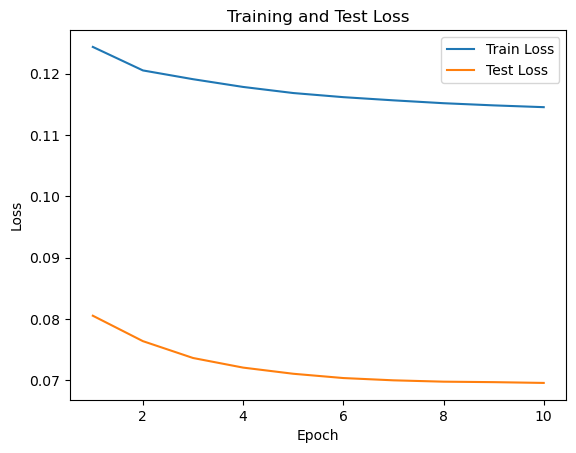

In [37]:
plot_losses(results)